In [1]:
import numpy as np
import pandas as pd
import sys, os
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from supDem import *
from rollingHorizon import *
from plotRes import *
from MixedBNE import *
from plotMBNE import main_plottingMNE

# Supply and Demand

In [18]:
dfDemand,s_others_yearly,e_others_yearly=SupDem(save=False)
indSupply,indDemand=indSupDem(dfDemand,s_others_yearly,e_others_yearly)

Adjusted number of community panels to: 32000


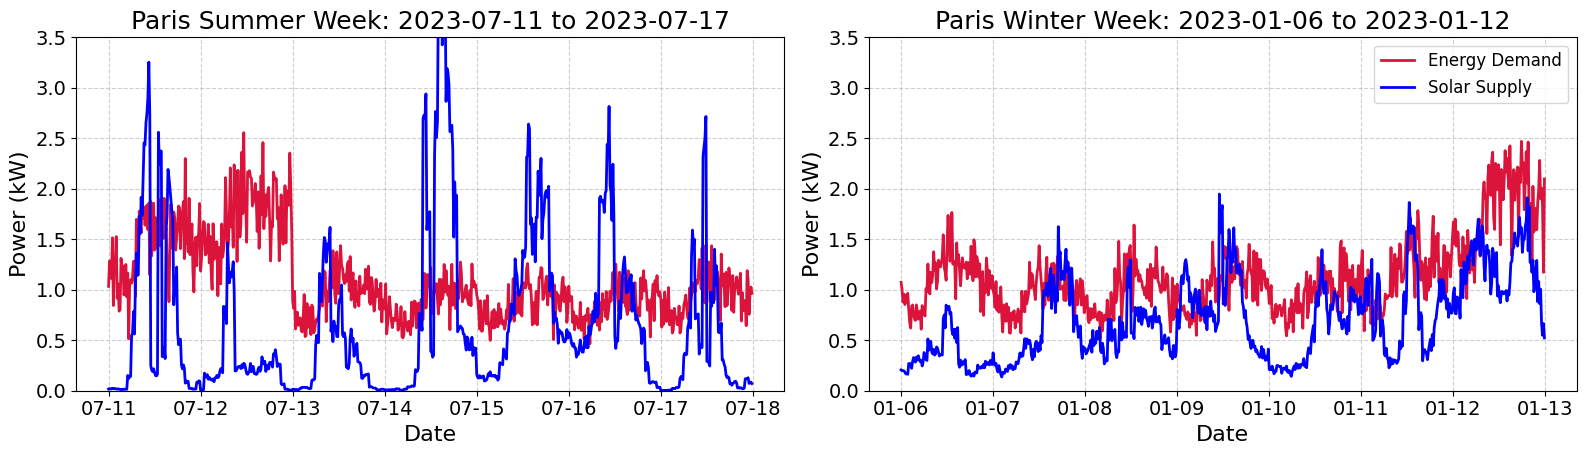

In [19]:
plotSummerWeek(indDemand,indSupply,start_date_summer = '2023-07-11',end_date_summer = '2023-07-17')


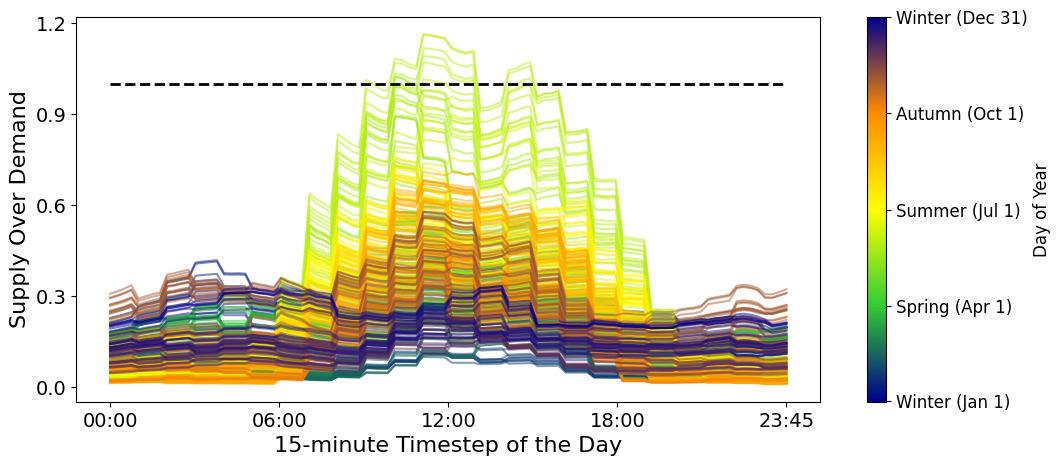

In [20]:
plotSD(dfDemand,s_others_yearly, e_others_yearly)

# Prosumer-Level Gains from Decentralization

In [37]:
simulation_index = indDemand.index
indDemand = pd.DataFrame(indDemand)
indDemand.columns = ['demand_kw']
individual_demand_profile=pd.read_csv('data/individual_demand_profile.csv', index_col=0, parse_dates=True)
new_demand_profile = generate_night_owl_profile(base_index=simulation_index,)

# Assuming prosumer's generation is from the individual supply profile
omega_yearly = pd.read_csv('data/individual_supply_profile.csv', index_col=0, parse_dates=True)
omega_yearly.columns = ['supply_kw'] # Rename column for clarity

# Remove timezone information to make all datetime indices compatible
s_others_yearlyT = pd.DataFrame(s_others_yearly)
s_others_yearlyT.index = s_others_yearly.index.tz_localize(None)
s_others_yearlyT.columns = ['supply_kw']
s_others_yearlyT["supply_kw"]=s_others_yearlyT["supply_kw"].values+e_others_yearly.values
omega_yearly.index = omega_yearly.index.tz_localize(None)

dfDemand.columns = ['demand_kw']
# 2. Set alpha_base as 75% of individual demand (this is a timeseries)
pct_flex    = 0.3   ## PCT of flex consumption need
alpha_base_yearly = (1-pct_flex)* new_demand_profile['demand_kw']



# 3. Define Simulation Parameters
# Prosumer parameters
B           = 10.0  ## BATTERY CAPACITY (BATTERY STORES PUT TO B kw)
b0_initial  = 5.0   ## INITIAL BATTERY STATE
X           = 5.0   ## MAXIMUM ENERGY TRANSACTION WITH THE GRID PER TIME UNIT
K_max       = 5.0   ## MAXIMUM BATTERY CHARGE/DISCHARGE POWER (in kW)
TotalDays = 360
L_input = 4      # Fixed lookahead window
T = 24 * 4       # Time steps per day (15-minute intervals)
gamma_day = 0.99     # Epoch discount rate
gamma_hourly = gamma_day**(1/T)
hours = np.arange(0,24,24/T)
hourCreusePleine =['c','c','c','c','c','c',
                   'p','p','p','p','p','p',
                   'c',
                   'p','p','p','p','p','p','p','p','p','p',
                   'c',]
HP=0.2146
HC=0.1696
lamOverPrice=0.0886
lam_under = np.full(T, lamOverPrice)
lam_over  = np.ones(T,)
for j in range(T):
    if hourCreusePleine[floor(hours[j])]=='p':lam_over[j]=HP
    else: lam_over[j]=HC
alpha_base_yearly_T = np.zeros((360,L_input+1))
unique_days = (indDemand['demand_kw']).index.normalize().unique()
sim_days_slice = slice(unique_days[0], unique_days[TotalDays-1] + pd.Timedelta(days=1) - pd.Timedelta(minutes=15))
alpha_base_daily = indDemand['demand_kw'].loc[sim_days_slice].values.reshape(TotalDays, T)*(1-pct_flex)
alpha_flex_day = np.sum(alpha_base_daily,1)*pct_flex/(1-pct_flex)


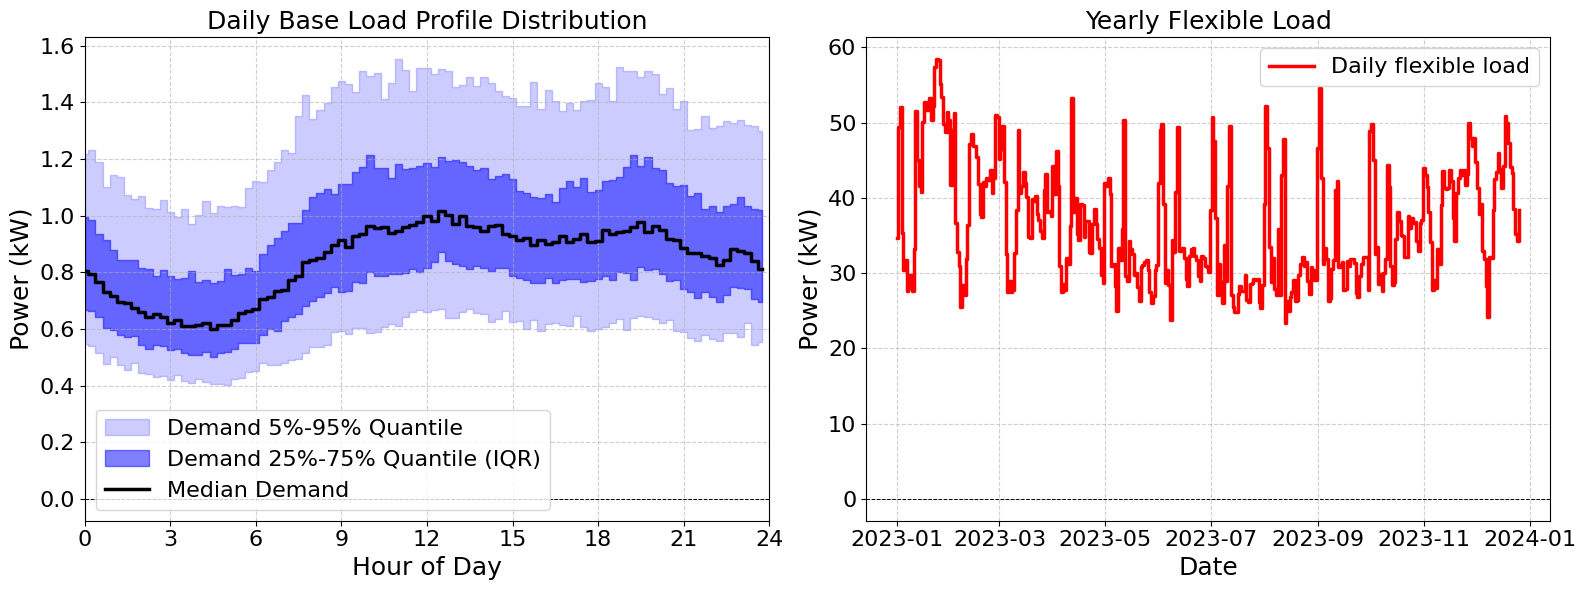

In [22]:
plotBaseFlexLoad(T,alpha_base_daily,unique_days,alpha_flex_day)

In [23]:
try:
    RHresults=pd.read_csv('data/simulation_results.csv')
except:
    RHresults=runRH(T,360,alpha_base_yearly,b0_initial,L_input,
          omega_yearly,s_others_yearlyT,dfDemand,
          new_demand_profile,pct_flex,alpha_base_yearly_T,
          B, X, K_max,
          lam_under, lam_over, gamma_hourly,
          individual_demand_profile
          )
k_dayT = RHresults['battery_charge_discharge_kw'].values.reshape(TotalDays, T)
xnet_dayT = RHresults['net_grid_trade_kw'].values.reshape(TotalDays, T)
soc_dayT = RHresults['battery_soc_kwh'].values.reshape(TotalDays, T)

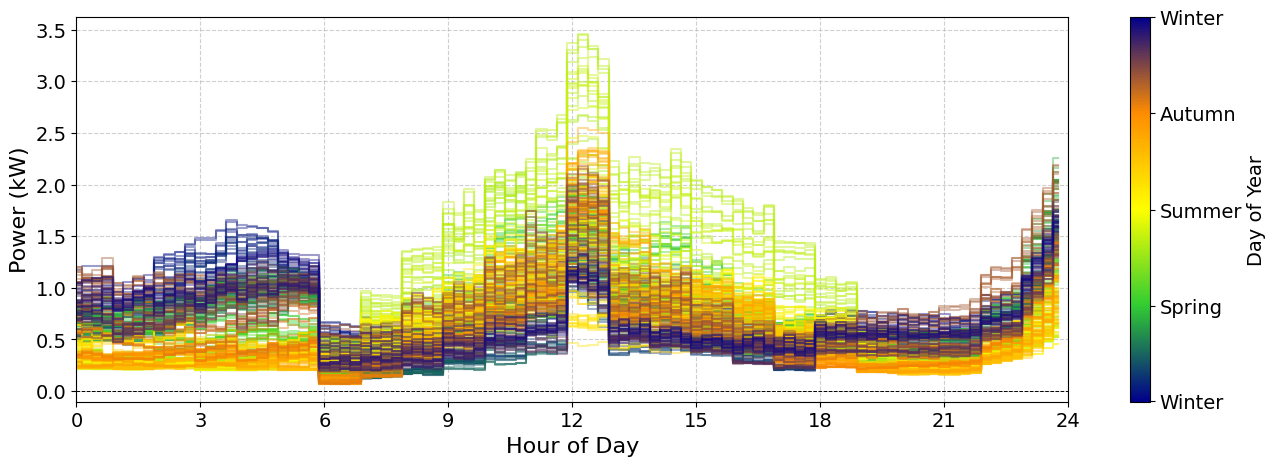

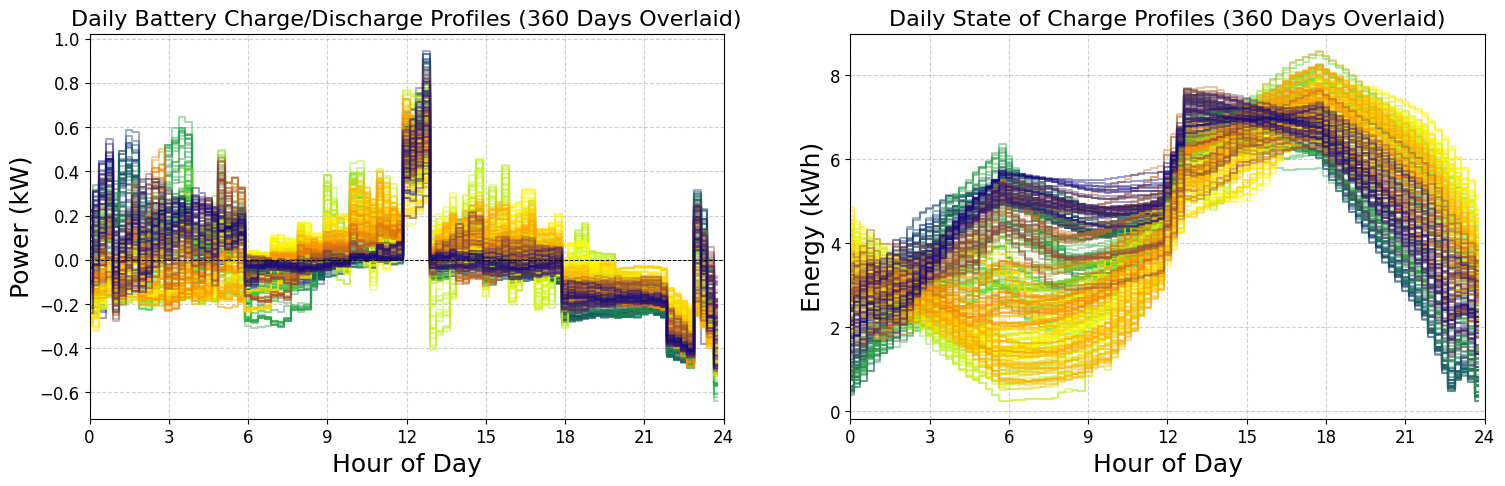

In [24]:
plotGridRes(T,k_dayT,xnet_dayT,soc_dayT,unique_days,TotalDays,omega_yearly)

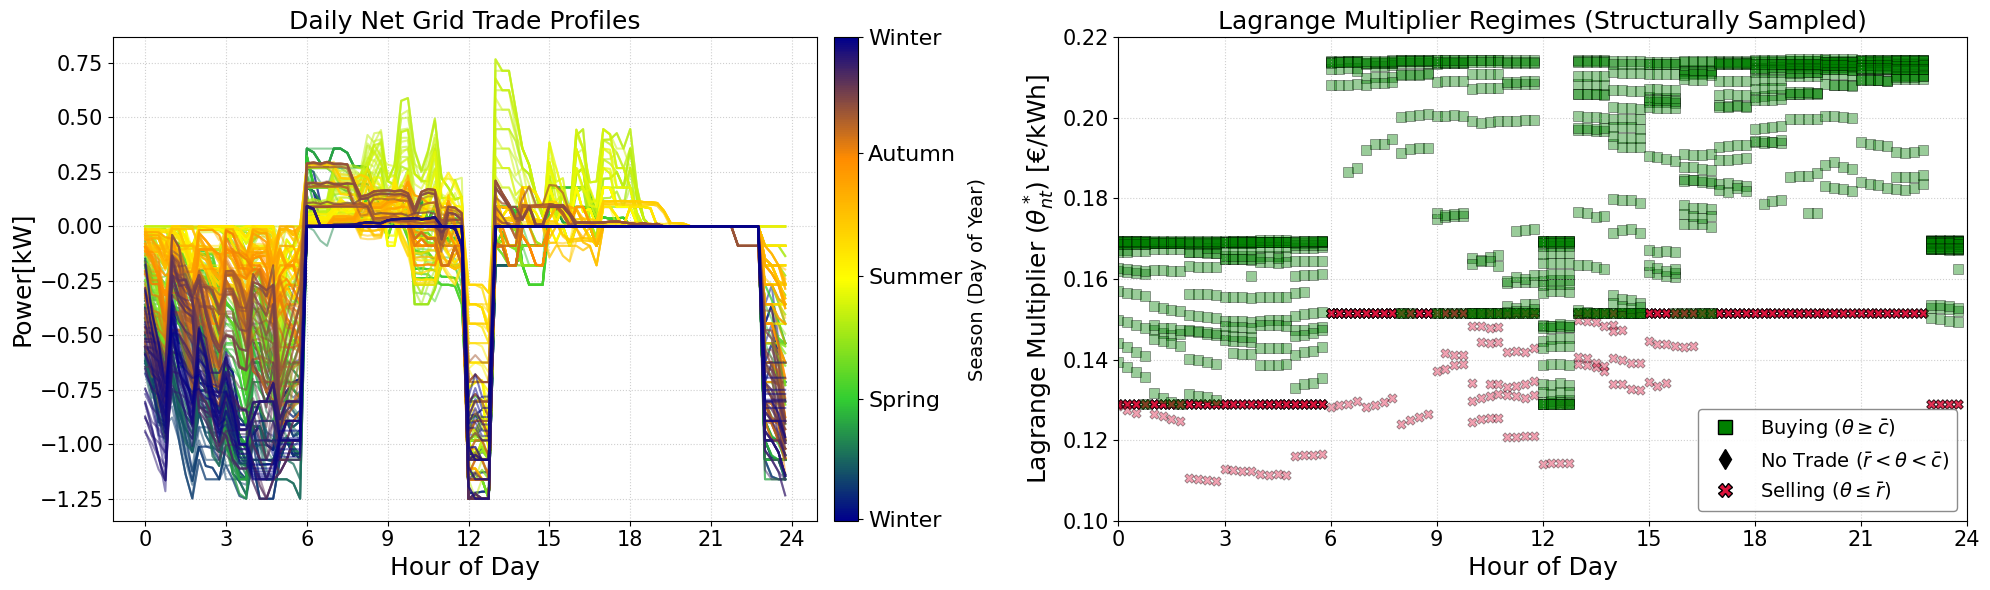

In [25]:
t_daily = np.arange(0, 24, 24 / T) # Time axis for a single day
plotLag(RHresults,xnet_dayT,t_daily)

In [ ]:
s_others_daily = s_others_yearlyT.loc[sim_days_slice]['supply_kw'].values.reshape(TotalDays, T) # Community Supply
d_others_daily = dfDemand.loc[sim_days_slice]['demand_kw'].values.reshape(TotalDays, T) # Community Demand
cum_profits_amm_exact,cum_profits_no_amm=AMMproft(k_dayT,T,s_others_daily,
             d_others_daily,lam_under,lam_over,
             save=False)

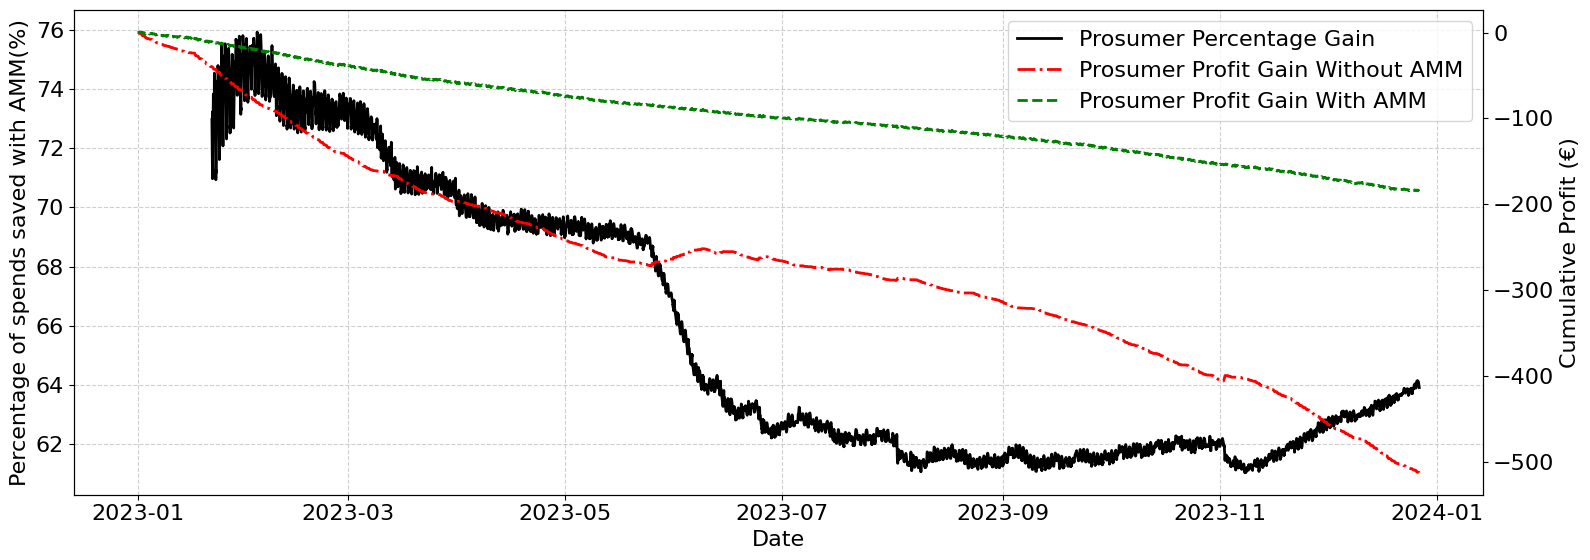

In [ ]:
plotcumProf(T,s_others_yearly,cum_profits_amm_exact,cum_profits_no_amm)

# Grid-Level Gains from Decentralization

In [80]:
conSin = np.genfromtxt("data/sinCons.txt",delimiter=";")
windSin = np.genfromtxt("data/sinWind.txt",delimiter=";")
solarSin = np.genfromtxt("data/sinSolar.txt",delimiter=";")
DC = np.genfromtxt("data/depthConsumption.txt",delimiter=";")
DS = np.genfromtxt("data/depthSolar.txt",delimiter=";")
DE = np.genfromtxt("data/depthWind.txt",delimiter=";")
DCN = np.genfromtxt("data/depthConsumption_N.txt",delimiter=";")
DSN = np.genfromtxt("data/depthSolar_N.txt",delimiter=";")
DEN = np.genfromtxt("data/depthWind_N.txt",delimiter=";")

summerStart,summerEnd="2023-06-01","2023-08-31"

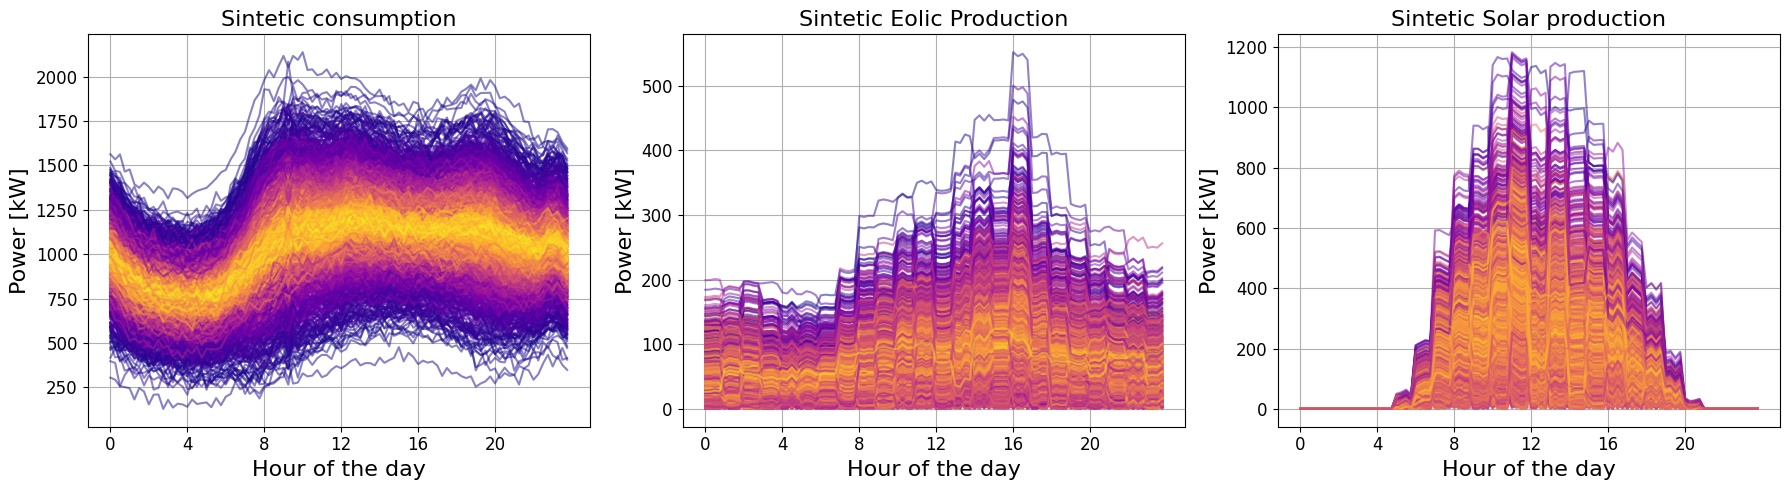

In [ ]:
plotSimData(conSin,windSin,solarSin,DC,DE,DS,dfDemand,summerStart,summerEnd)

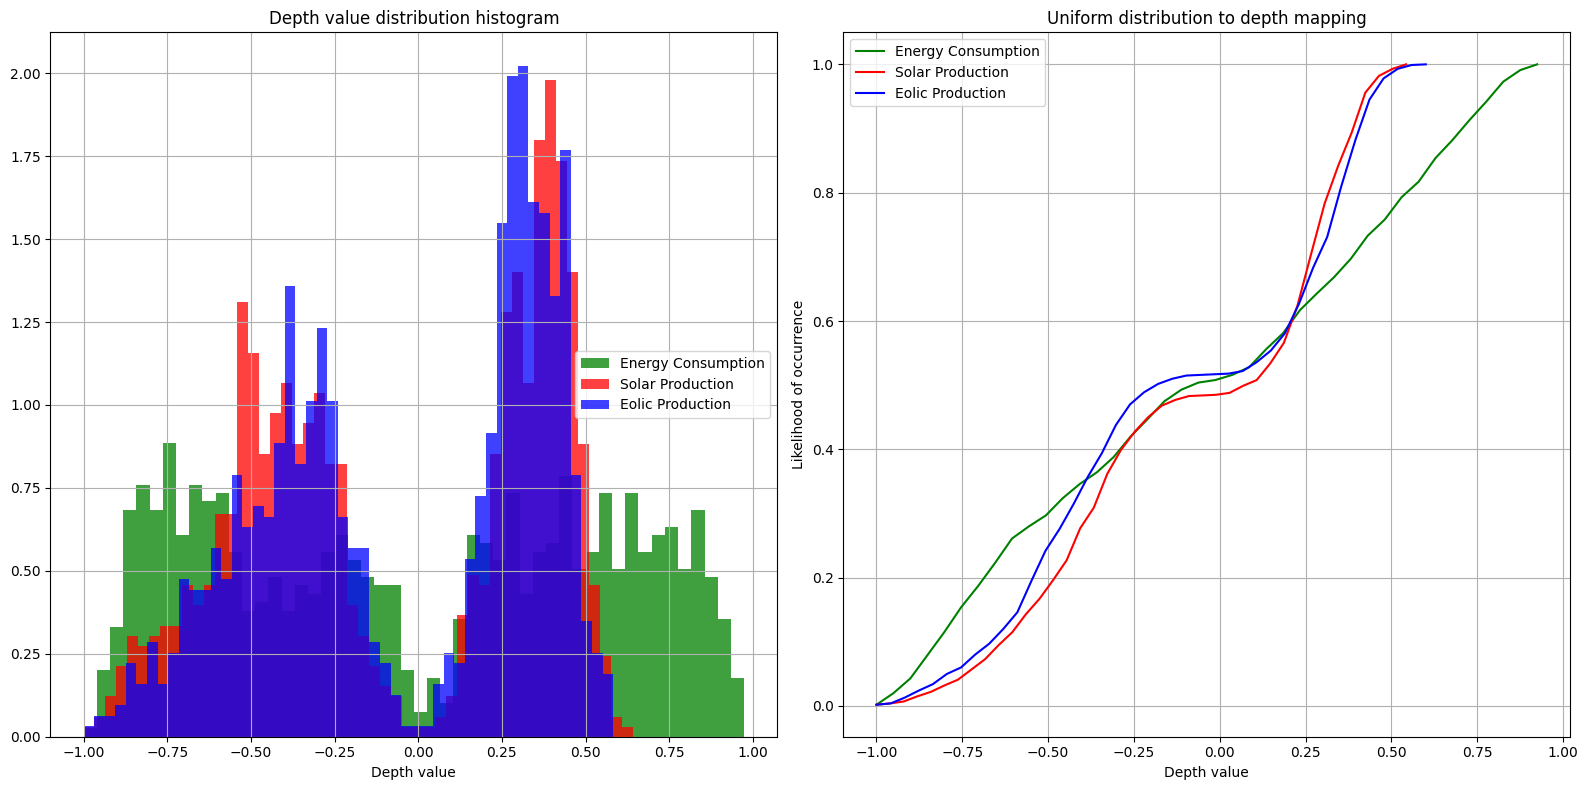

In [ ]:
plotDepthHist(DCN,DSN,DEN)

In [83]:
SCALE_FACTOR = 1000.0
LOAD_ADJUST_FACTOR = 0.5 
SOLAR_ADJUST_FACTOR = 2.0
WIND_ADJUST_FACTOR = 5.0
CC=(np.genfromtxt('data/sinCons.txt', delimiter=';')*.7 / SCALE_FACTOR) * LOAD_ADJUST_FACTOR
CS=(np.genfromtxt('data/sinSolar.txt', delimiter=';') / SCALE_FACTOR) * SOLAR_ADJUST_FACTOR
CW=(np.genfromtxt('data/sinWind.txt', delimiter=';') / SCALE_FACTOR) * WIND_ADJUST_FACTOR
nBinsC=ceil((max(DCN)-min(DCN))/(2*(np.quantile(DCN,.75)-np.quantile(DCN,.25))*DCN.shape[0]**(-1/3)))
freqC,binsC=np.histogram(DCN,bins=nBinsC)
cumulativeC = np.cumsum(freqC)/1000
centerC_depth=(binsC[1:]+binsC[:-1])/2
centerC_curve=np.empty((centerC_depth.shape[0],CC.shape[1]))
indicesC=np.minimum(np.digitize(DCN,binsC),centerC_depth.shape[0])-1
for i in range(centerC_depth.shape[0]):
    centerC_curve[i]=CC[np.argmin(np.abs(centerC_depth[i]-DCN))]

nBinsS=ceil((max(DSN)-min(DSN))/(2*(np.quantile(DSN,.75)-np.quantile(DSN,.25))*DSN.shape[0]**(-1/3)))
freqS,binsS=np.histogram(DSN,bins=nBinsS)
cumulativeS = np.cumsum(freqS)/1000
centerS_depth=(binsS[1:]+binsS[:-1])/2
centerS_curve=np.empty((centerS_depth.shape[0],CS.shape[1]))
indicesS=np.minimum(np.digitize(DSN,binsS),centerS_depth.shape[0])-1
for i in range(centerS_depth.shape[0]):
    centerS_curve[i]=CS[np.argmin(np.abs(centerS_depth[i]-DSN))]

nBinsW=ceil((max(DEN)-min(DEN))/(2*(np.quantile(DEN,.75)-np.quantile(DEN,.25))*DEN.shape[0]**(-1/3)))
freqW,binsW=np.histogram(DEN,bins=nBinsW)
cumulativeW = np.cumsum(freqW)/1000
centerW_depth=(binsW[1:]+binsW[:-1])/2
centerW_curve=np.empty((centerW_depth.shape[0],CW.shape[1]))
indicesW=np.minimum(np.digitize(DEN,binsW),centerW_depth.shape[0])-1
for i in range(centerW_depth.shape[0]):
    centerW_curve[i]=CW[np.argmin(np.abs(centerW_depth[i]-DEN))]


In [ ]:
MBNE(centerC_curve, centerS_curve, centerW_curve,
         cumulativeC,cumulativeS,cumulativeW,centerC_depth,centerS_depth,centerW_depth,
         T,)

In [2]:
filepath = 'data/mpe_simulation_results.pkl'
if not os.path.exists(filepath):
    print(f"Error: Results file not found at '{filepath}'\nPlease run the MPE simulation script first.")
print(f"--- Loading results from '{filepath}' ---")
with open(filepath, 'rb') as f:
    resultsMNE = pickle.load(f)

--- Loading results from 'data/mpe_simulation_results.pkl' ---


--- Mapping Agents to Bins ---
--- Plotting SoC evolution over epochs ---
--- Plotting Profit Histograms ---
--- Plotting Welfare Gains ---


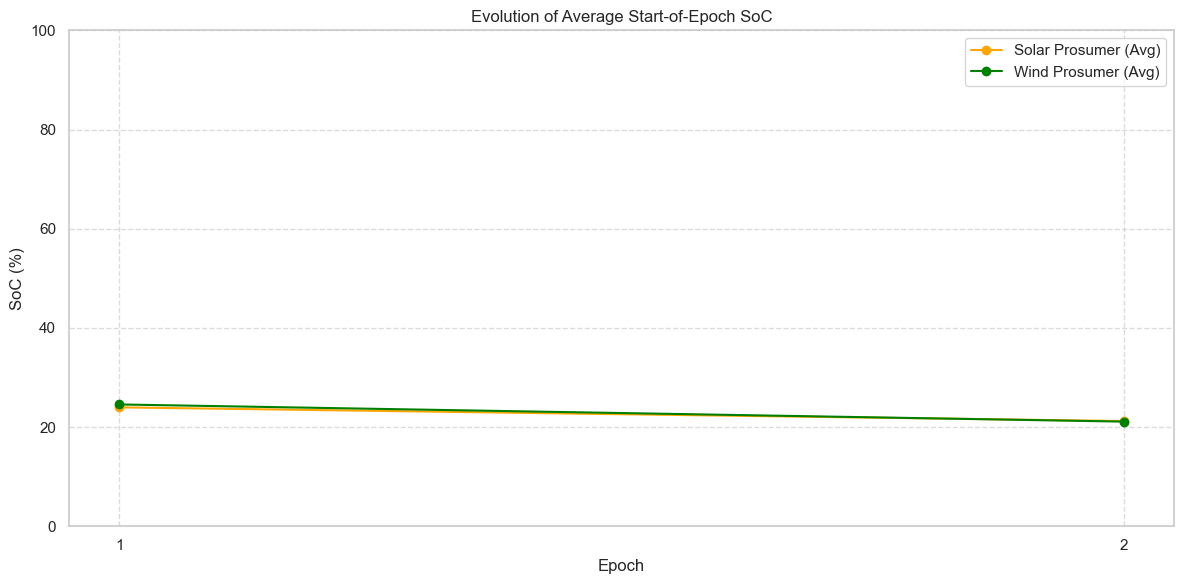

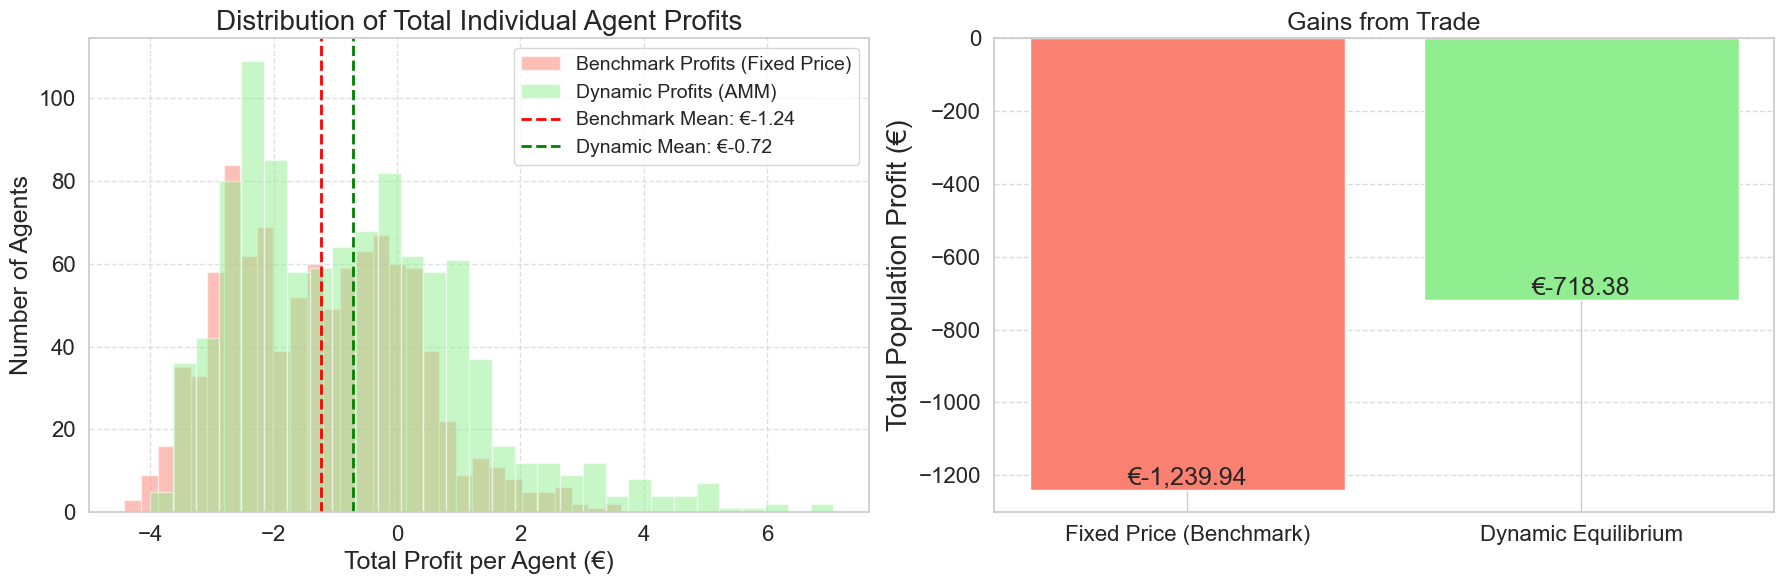

--- Plotting Aggregate Master Figure (with Secondary Axis) ---

--- Generating Price Band Data ---


Sampling Epochs: 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]

--- Plotting Price Bands (Cloud) ---
--- Plotting 3x2 Layout (Top-Left: Population Consumption) ---


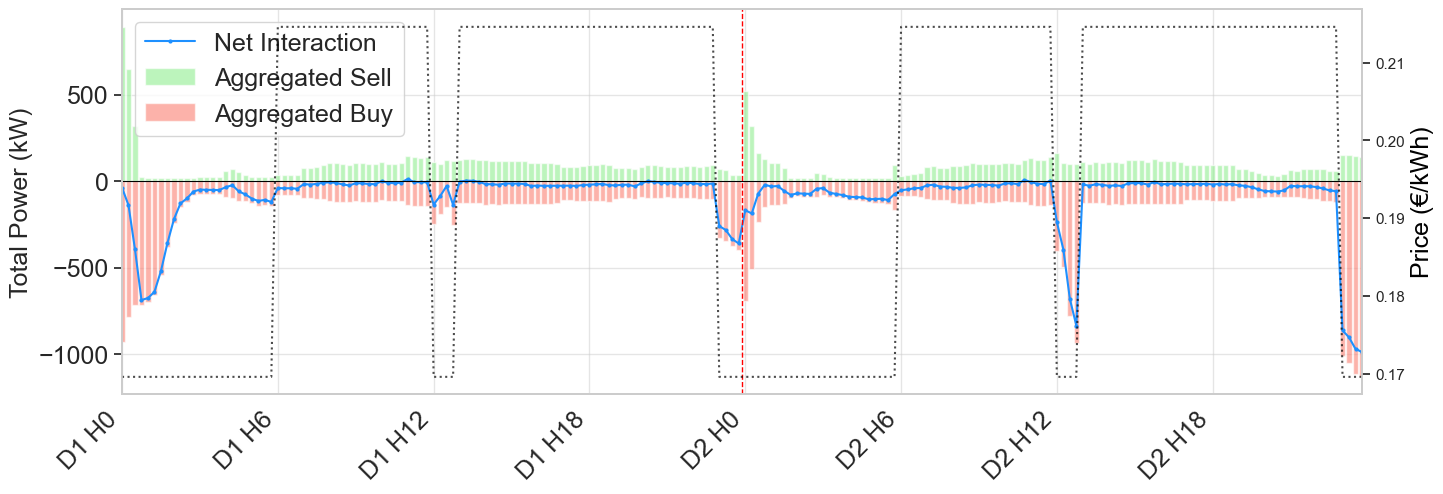

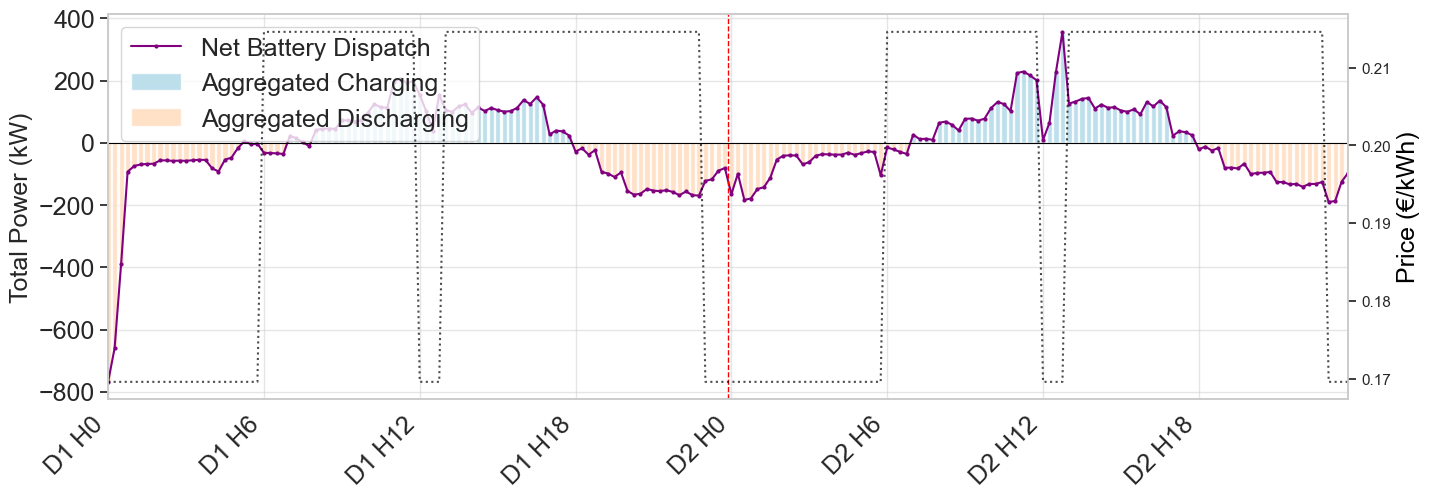

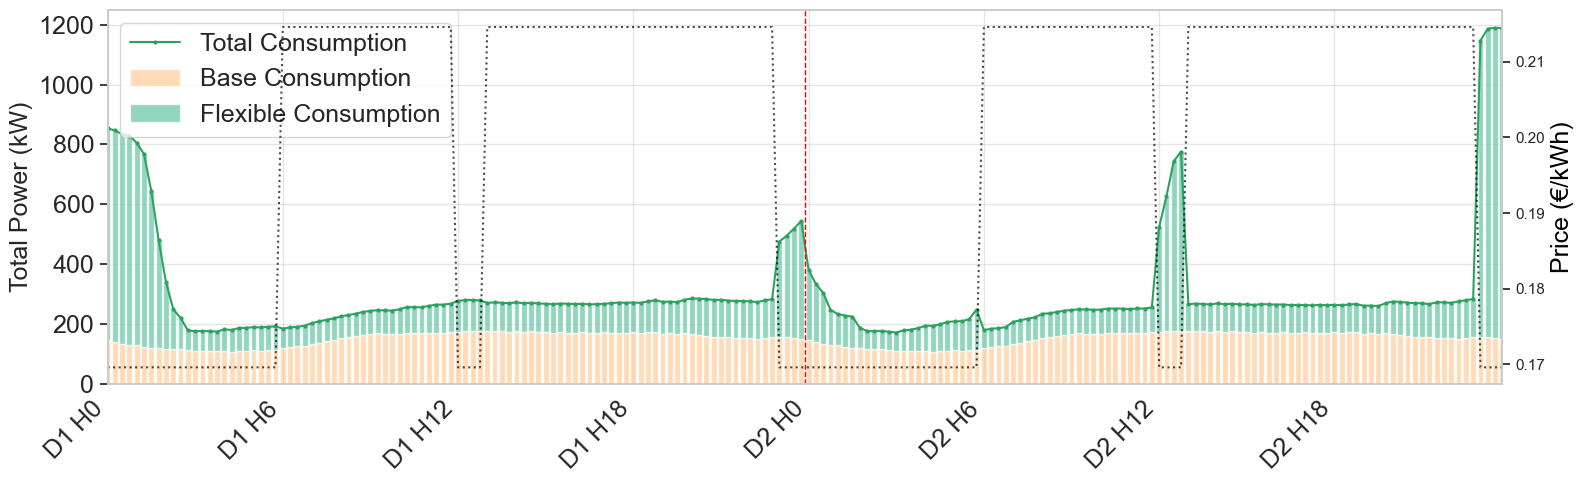

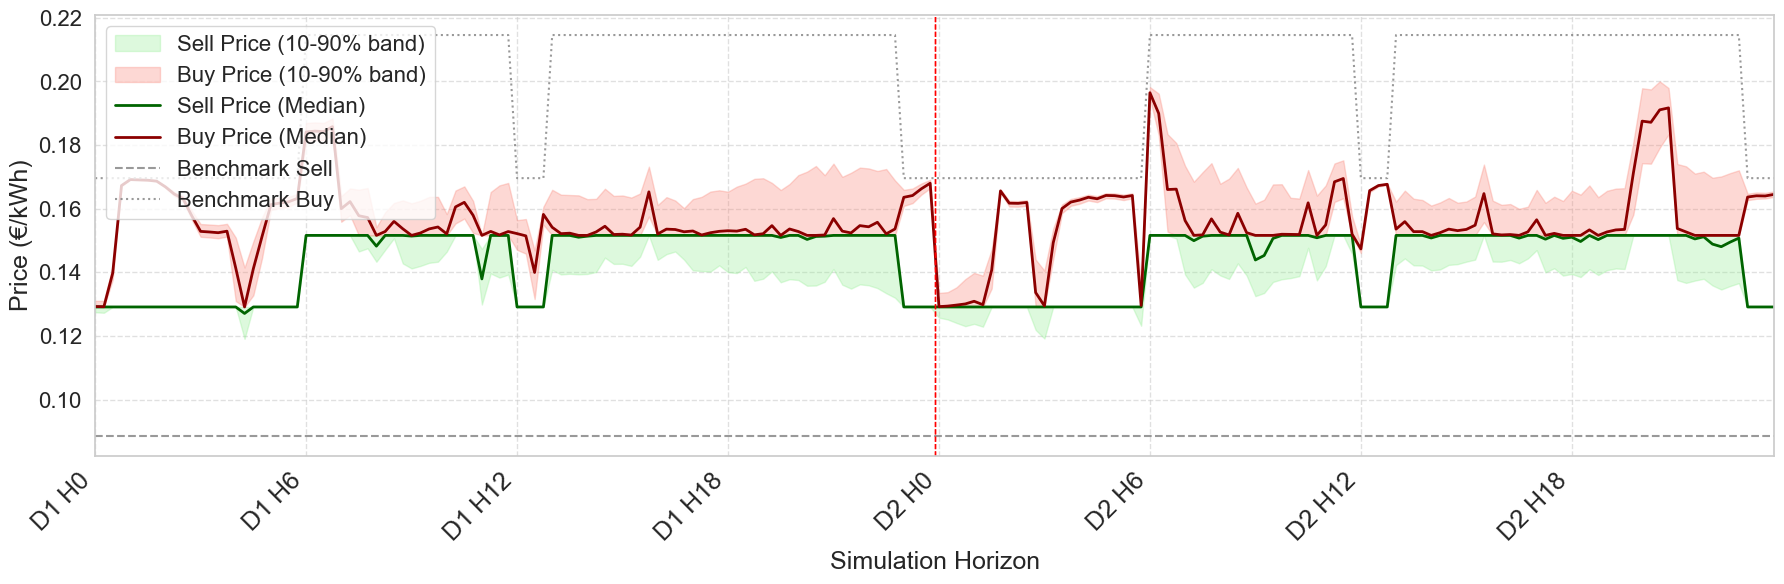

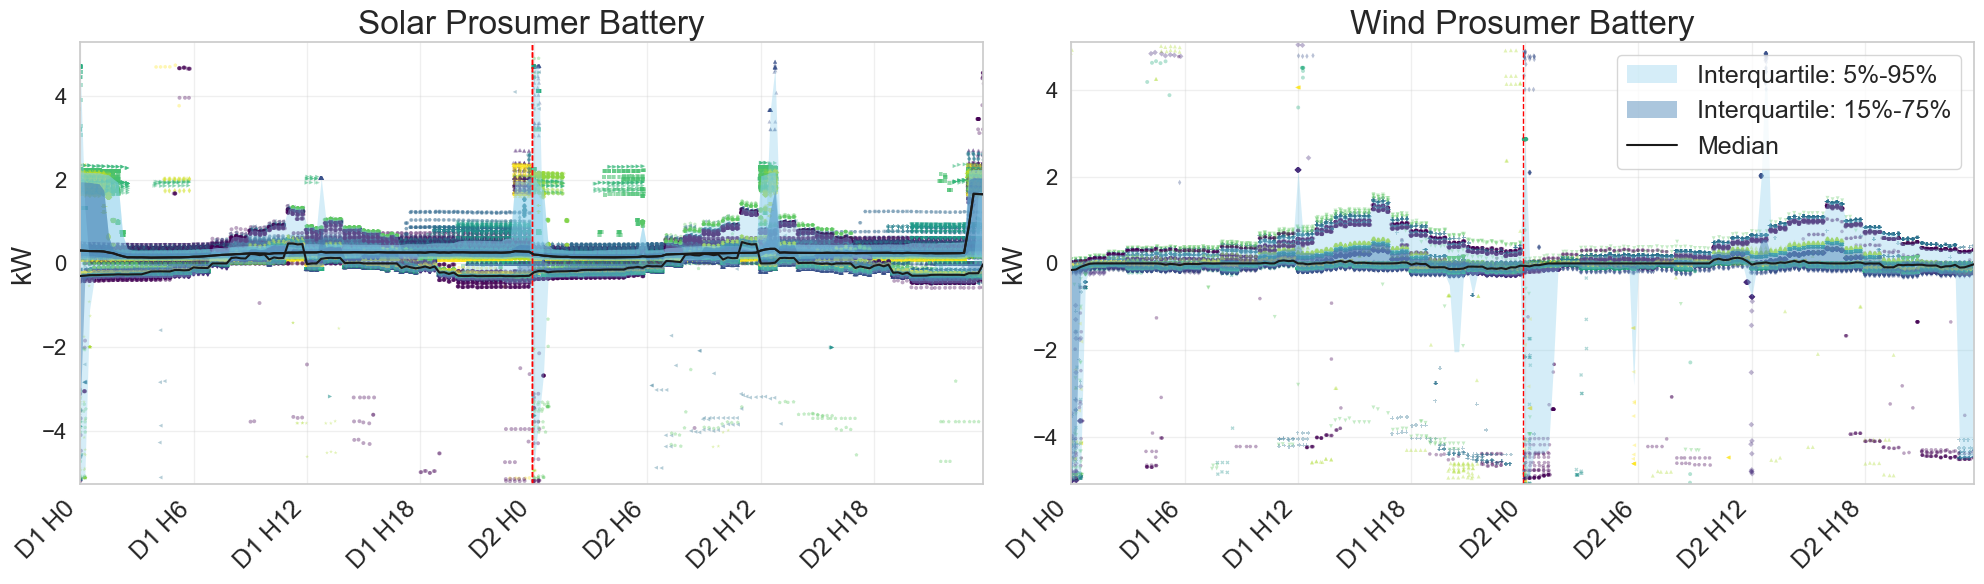

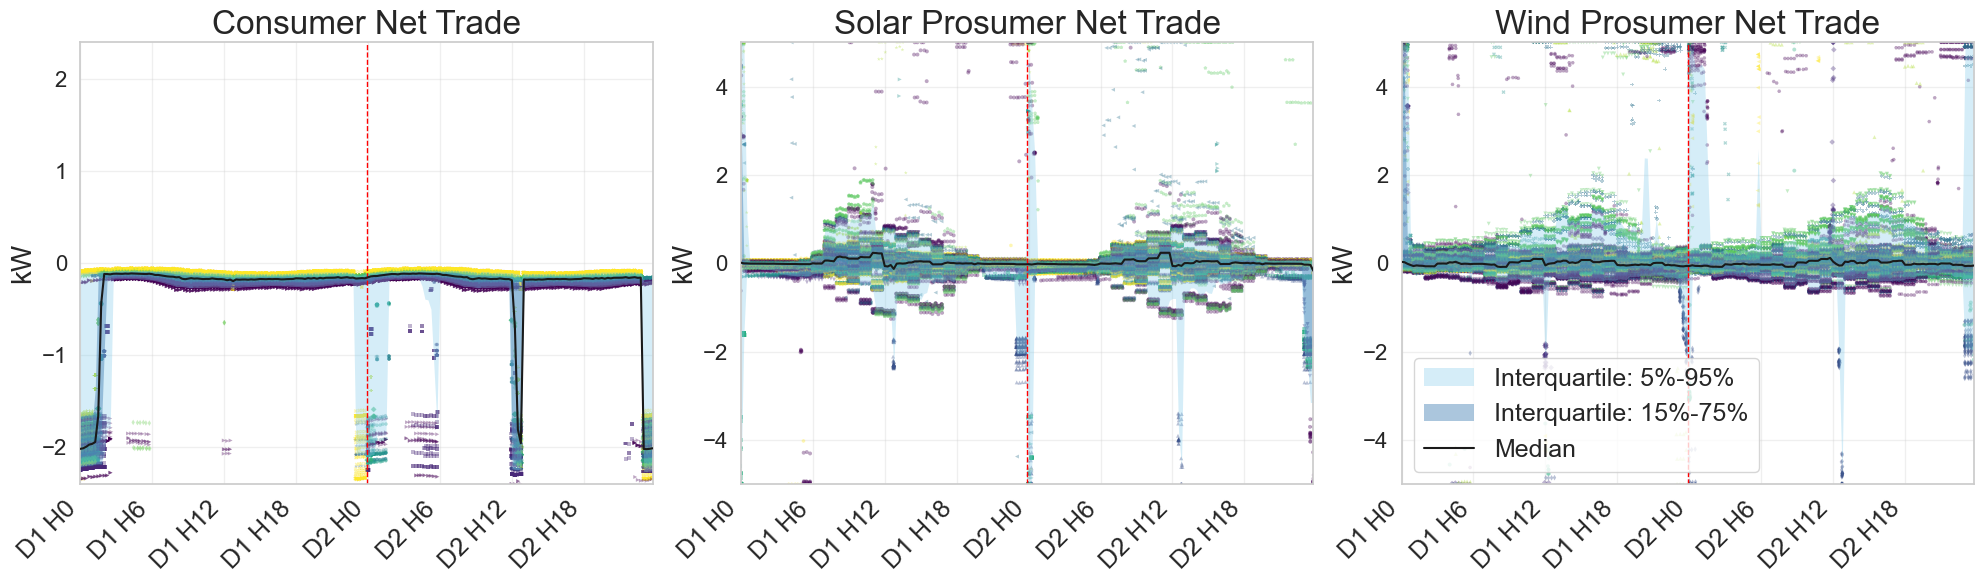

In [3]:
main_plottingMNE(resultsMNE)